Tissue mask using this model

|2024-04-23|15:28:44.262| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
|2024-04-23|15:28:44.265| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.


'Processing TCGA-08-0518-01Z-00-DX8.01f2c18c-09a8-4837-8619-62f1c9b82669.svs'
'Loading model to cpu'


  0%|          | 0/684 [00:00<?, ?it/s]

|2024-04-23|15:28:44.269| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
|2024-04-23|15:28:44.270| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
|2024-04-23|15:28:45.171| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
|2024-04-23|15:28:45.171| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
|2024-04-23|15:28:45.953| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
|2024-04-23|15:28:45.953| [WAR

'Task finished successfully'
{'objective_power': 20.0, 'slide_dimensions': (72003, 37485), 'level_count': 3, 'level_dimensions': ((72003, 37485), (18000, 9371), (4500, 2342)), 'level_downsamples': [1.0, 4.000136689431935, 16.003108738969544], 'vendor': 'aperio', 'mpp': (0.5015, 0.5015), 'file_path': PosixPath('/Users/wildsquirrel/Library/CloudStorage/OneDrive-UniversityofWarwick/tissue_mask_demo_wsi/TCGA-08-0518-01Z-00-DX8.01f2c18c-09a8-4837-8619-62f1c9b82669.svs'), 'axes': 'YXS'}


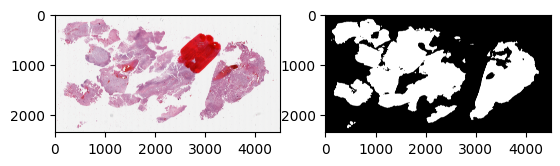

In [3]:
from tiatoolbox.wsicore.wsireader import WSIReader
from tissue_masker_lite import get_mask
import matplotlib.pyplot as plt

input_wsi = "/Users/wildsquirrel/Library/CloudStorage/OneDrive-UniversityofWarwick/tissue_mask_demo_wsi/TCGA-08-0518-01Z-00-DX8.01f2c18c-09a8-4837-8619-62f1c9b82669.svs"
save_dir = "./output"
model_weight_path = "tissue_masker_lite/model_weights/model_54.pth"
mask = get_mask(
    wsi_path=input_wsi,
    save_dir=save_dir,
    model_weight=model_weight_path,
    threshold=0.5,
    device="cpu",
    return_mask=True,
    save_mask=False,
)
reader = WSIReader.open(input_wsi)
print(reader.info.as_dict())
thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")
fig, axes = plt.subplots(1, 2)
axes[0].imshow(thumbnail)
axes[1].imshow(mask, cmap="gray")
plt.show()

Tissue mask using tiatoolbox WSIReader.tissue_mask()

In [ ]:
import numpy as np

mask_old = reader.tissue_mask().slide_thumbnail()
mask_old = np.where(mask_old >= 0.5, 1, 0)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(thumbnail)
axes[1].imshow(mask_old, cmap="gray")
plt.show()

Tissue mask using tiatoolbox pretained fcn-tissue_mask model

In [ ]:
from tiatoolbox.models.engine.semantic_segmentor import (
    SemanticSegmentor,
    IOSegmentorConfig,
)
import shutil

tissue_segmentor = SemanticSegmentor(
    pretrained_model="fcn-tissue_mask",
    num_loader_workers=1,
    batch_size=1,
    auto_generate_mask=False,
)

tissue_segmentor_config = IOSegmentorConfig(
    input_resolutions=[{"units": "mpp", "resolution": 2}],
    output_resolutions=[{"units": "mpp", "resolution": 2}],
    patch_input_shape=[1024, 1024],
    patch_output_shape=[512, 512],
    stride_shape=[256, 256],
    save_resolution={"units": "mpp", "resolution": 8},
)


wsi_path = input_wsi
shutil.rmtree("tissue_masker_lite/sample_tile_results", ignore_errors=True)
output = tissue_segmentor.predict(
    [wsi_path],
    save_dir="sample_tile_results/",
    mode="wsi",
    ioconfig=tissue_segmentor_config,
    on_gpu=False,
    crash_on_exception=True,
)

wsi_prediction_raw = np.load(
    "tissue_masker_lite/sample_tile_results/0.raw.0.npy",
)  # Loading the first prediction [0] based on the output address [1]

# Simple processing of the raw prediction to generate semantic segmentation task
wsi_prediction = np.argmax(
    wsi_prediction_raw,
    axis=-1,
)
# [WSI overview extraction]
# Now reading the WSI to extract it's overview
wsi = WSIReader.open(wsi_path)

# using the prediction save_resolution to create the wsi overview at the same resolution
overview_info = tissue_segmentor_config.save_resolution

# extracting slide overview using `slide_thumbnail` method
wsi_overview = wsi.slide_thumbnail(
    resolution=overview_info["resolution"],
    units=overview_info["units"],
)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(wsi_overview)
axes[1].imshow(wsi_prediction, cmap="gray")
plt.show()